In [22]:
#imports
import pandas as pd
import numpy as np
import acquire
import prepare
import env
import os
import seaborn as sns
import matplotlib.pyplot as plt
import viz
#for hypothesis tests
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
# our basic evaluation metric: mean squared error
from sklearn.metrics import mean_squared_error,explained_variance_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#get data
df = acquire.get_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
0,2.0,1.0,1174.0,155395.0,1937.0,6037.0
1,5.0,3.0,2299.0,283765.0,1977.0,6037.0
2,2.0,1.5,1008.0,332406.0,1964.0,6059.0
3,6.0,5.5,4041.0,1587088.0,2005.0,6059.0
4,2.0,2.0,1064.0,231539.0,1964.0,6059.0


In [4]:
df.shape

(52441, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   fips                          52441 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


In [6]:
#we have some nulls
df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
taxvaluedollarcnt                 1
yearbuilt                       116
fips                              0
dtype: int64

In [77]:
df.yearbuilt.value_counts(bins = 20)

(1953.9, 1960.8]      8546
(1947.0, 1953.9]      7389
(1960.8, 1967.7]      6112
(1967.7, 1974.6]      4117
(1974.6, 1981.5]      3892
(1981.5, 1988.4]      3057
(1988.4, 1995.3]      2983
(1995.3, 2002.2]      2942
(1940.1, 1947.0]      2884
(1919.4, 1926.3]      2702
(2002.2, 2009.1]      2331
(1933.2, 1940.1]      2021
(1926.3, 1933.2]      1393
(2009.1, 2016.0]       731
(1905.6, 1912.5]       581
(1912.5, 1919.4]       453
(1898.7, 1905.6]       140
(1891.8, 1898.7]        29
(1884.9, 1891.8]        19
(1877.861, 1884.9]       3
Name: yearbuilt, dtype: int64

In [7]:
#change columns names
df = df.rename(columns = {'bedroomcnt': 'bedroom', 'bathroomcnt':'bathroom', 'calculatedfinishedsquarefeet':'area',
       'taxvaluedollarcnt':'tax_value', 'yearbuilt':'year_built', 'fips':'county'})

In [8]:
df.columns

Index(['bedroom', 'bathroom', 'area', 'tax_value', 'year_built', 'county'], dtype='object')

In [9]:
#give fips actual names
df.county = df['county'].replace({6037:'Los Angeles',6059:'Orange',6111:'Ventura'})

In [10]:
df.county.unique()

array(['Los Angeles', 'Orange', 'Ventura'], dtype=object)

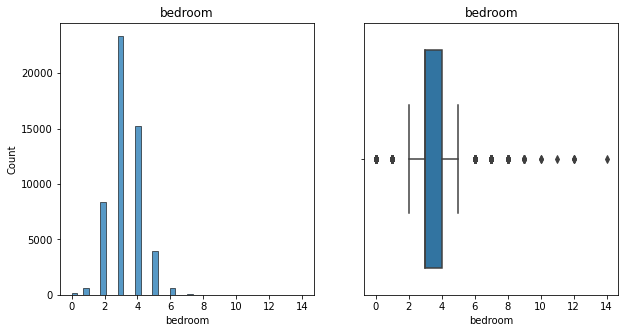

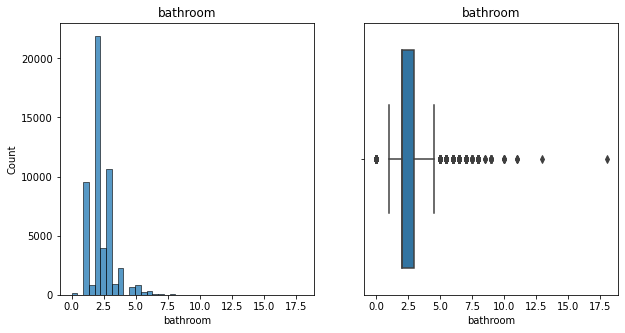

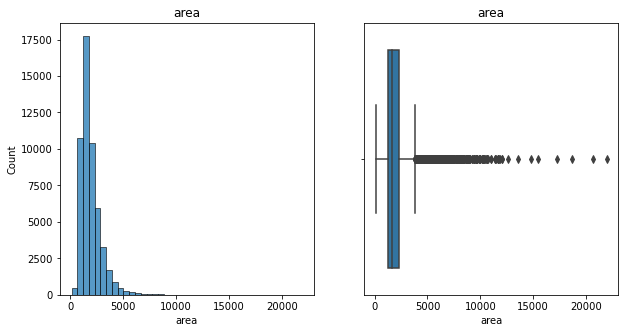

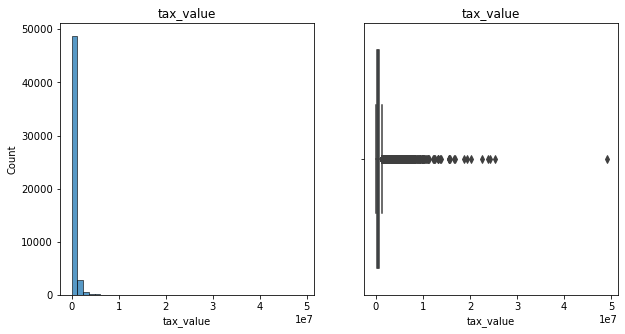

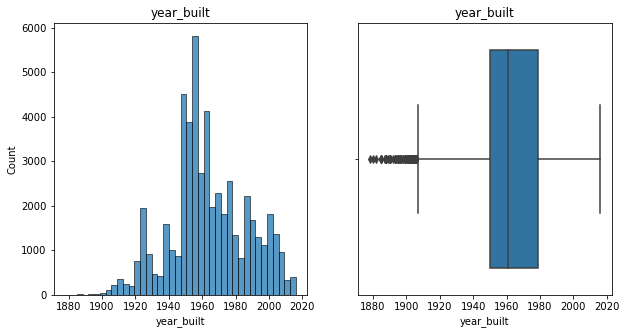

TypeError: Horizontal orientation requires numeric `x` variable.

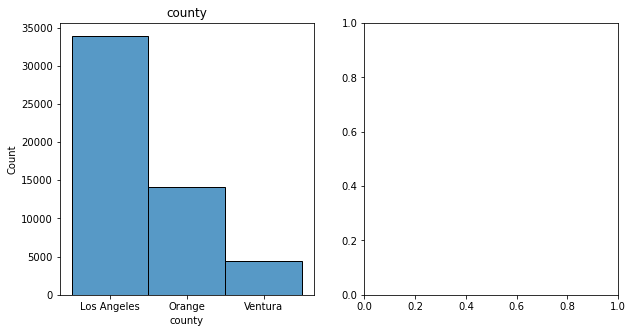

In [11]:
#plot histoplot and boxplot to see distribution of data
for i in df.columns:
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    sns.histplot(x= i, data = df, bins = 40)
    plt.title(i)
    
    plt.subplot(122)
    sns.boxplot(x=i, data =df)
    plt.title(i)
    plt.show()

In [12]:
#remove outliers
def remove_outliers(df, k, col_list):
     ''' remove outliers from a list of columns in a dataframe 
         and return that dataframe
     '''
     for col in col_list:

         q1, q3 = df[col].quantile([.25, .75])  # get quartiles

         iqr = q3 - q1   # calculate interquartile range

         upper_bound = q3 + k * iqr   # get upper bound
         lower_bound = q1 - k * iqr   # get lower bound

         # return dataframe without outliers

         df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

     return df

In [13]:
df = remove_outliers(df,1.5, ['bedroom', 'bathroom', 'area', 'tax_value', 'year_built'])
df.shape

(45241, 6)

In [14]:
45241/52441

0.8627028470090197

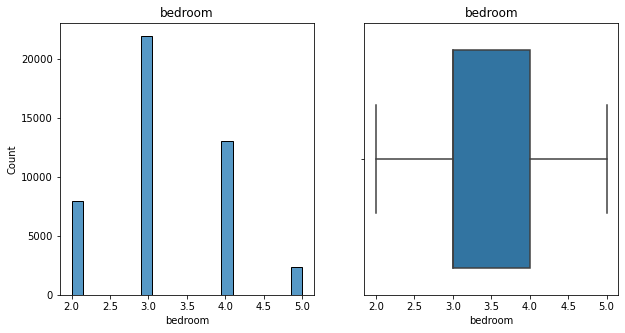

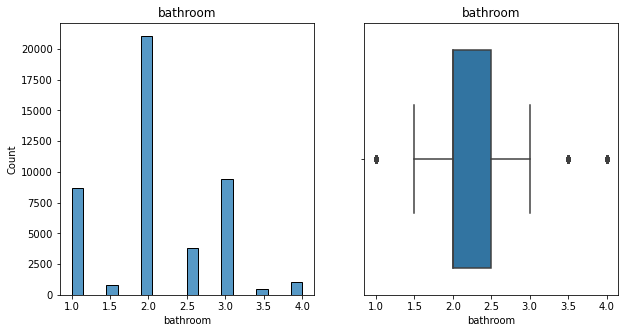

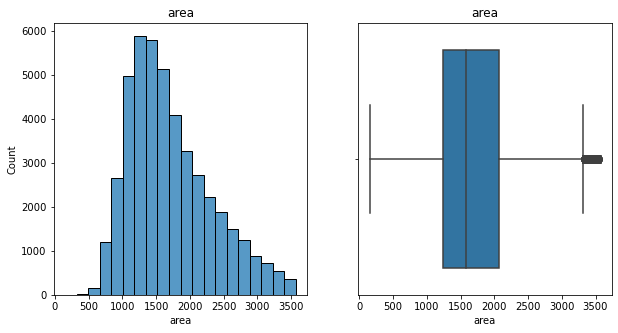

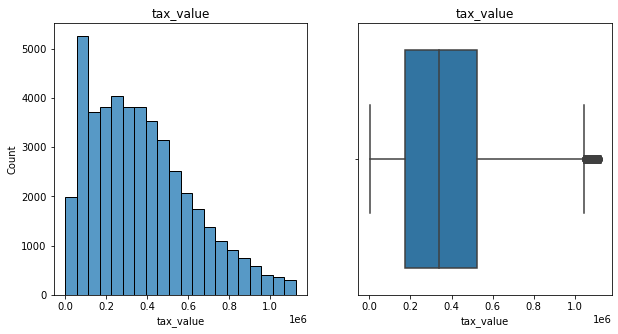

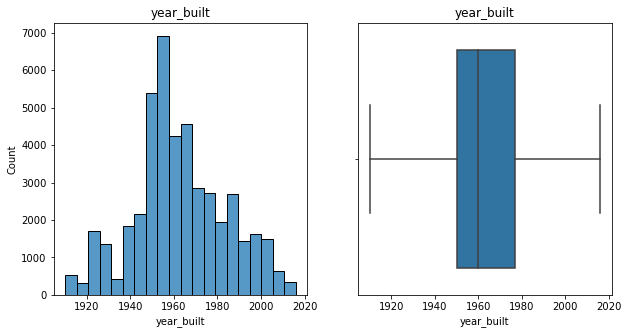

TypeError: Horizontal orientation requires numeric `x` variable.

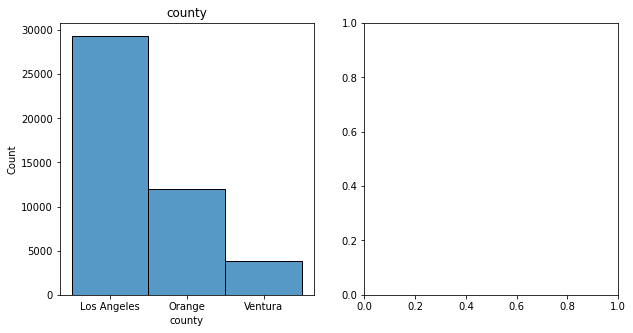

In [17]:
#plot histoplot and boxplot to see distribution of data
for i in df.columns:
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    sns.histplot(x= i, data = df, bins = 20)
    plt.title(i)
    
    plt.subplot(122)
    sns.boxplot(x=i, data =df)
    plt.title(i)
    plt.show()

In [4]:
zillow = prepare.prep_zillow_data(df)
train, validate, test = prepare.split_zillow_data(zillow)

In [5]:
train.shape

(25334, 6)

In [6]:
validate.shape

(10858, 6)

In [7]:
test.shape

(9049, 6)

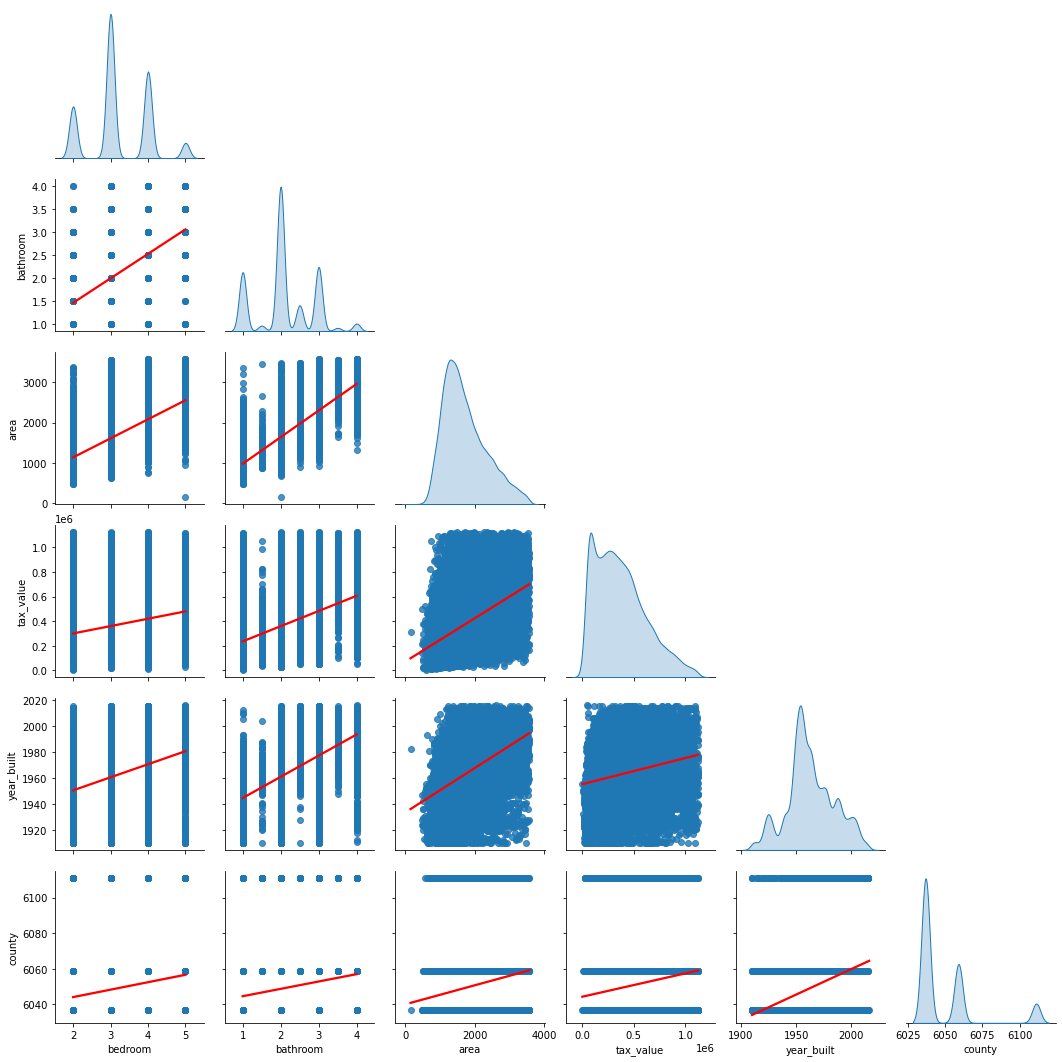

In [36]:
#vizualise pairplot
sns.pairplot(data=train, kind='reg', diag_kind='kde', corner = True, plot_kws={'line_kws':{'color':'red'}})

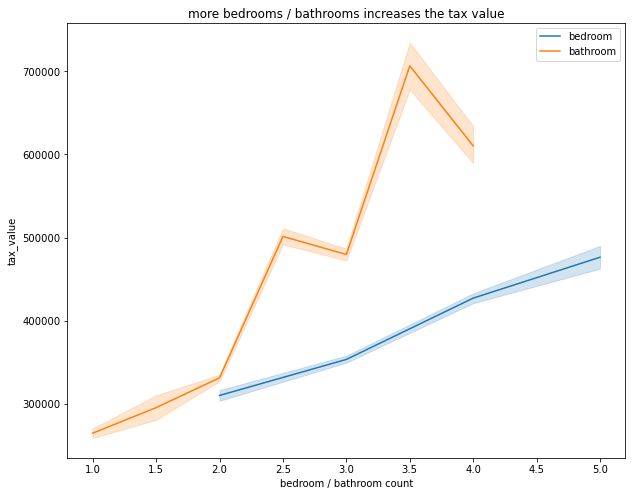

In [37]:
viz.show_lineplot(train)

In [39]:
train.head(1)

,bedroom,bathroom,area,tax_value,year_built,county
30536,5.0,3.0,3415.0,994000.0,1979.0,Orange


In [42]:
train["ratio"] = train.bedroom/train.bathroom
train.head()

,bedroom,bathroom,area,tax_value,year_built,county,ratio
30536,5.0,3.0,3415.0,994000.0,1979.0,Orange,1.666667
17269,3.0,2.0,1652.0,247632.0,1952.0,Los Angeles,1.500000
28117,4.0,3.0,1252.0,344761.0,1912.0,Los Angeles,1.333333
39745,5.0,2.5,2380.0,347513.0,1972.0,Orange,2.000000
6926,3.0,2.0,1268.0,386856.0,1969.0,Orange,1.500000


<AxesSubplot:xlabel='ratio', ylabel='tax_value'>

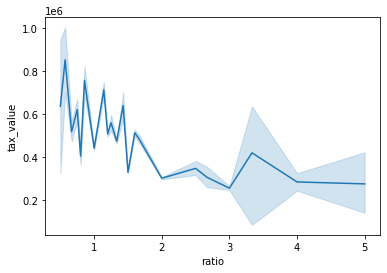

In [45]:
sns.lineplot(x = train.ratio, y= train.tax_value)

<AxesSubplot:xlabel='year_built', ylabel='tax_value'>

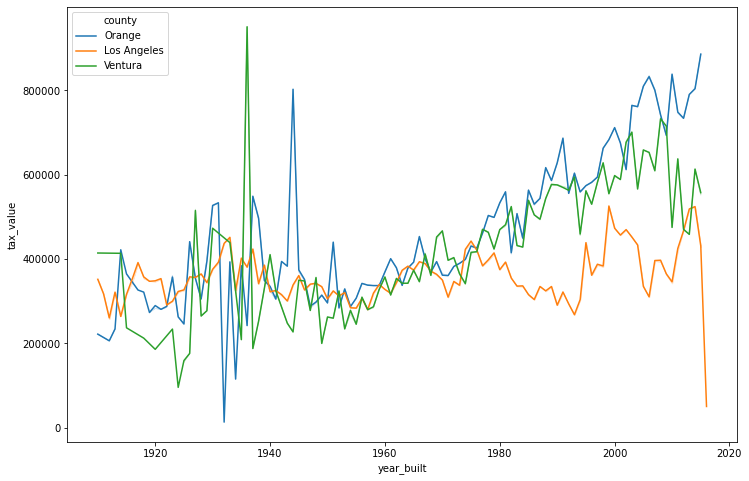

In [38]:

null_hyp = 'tax value for 4 bedroom property =< tax value for 2 bedroom property'
alt_hyp = 'tax value for 4 bedroom property > tax value for 2 bedroom property'
alpha = 0.05
one_bedroom_tax_value = train[train.bedroom ==2].tax_value
four_bedroom_tax_value = train[train.bedroom == 4].tax_value
t,p = stats.ttest_ind(one_bedroom_tax_value, four_bedroom_tax_value)
if p < alpha:
    print("reject null hypothesis" )
    print("we conclude ", alt_hyp)
else:
    print("fail to reject null hypothesis")
    print("we conclude", null_hyp)

reject null hypothesis
we conclude  tax value for 4 bedroom property > tax value for 2 bedroom property


In [39]:
null_hyp = 'tax value of 4 bathroom property =< tax value of 1 bathroom property'
alt_hyp = 'tax value of 4 bathroom property > tax value of 1 bathroom property'
one_bath_tax_value = train[train.bathroom == 1].tax_value
four_bedroom_tax_value = train[train.bathroom == 4].tax_value
t,p = stats.ttest_ind(one_bedroom_tax_value, four_bedroom_tax_value)
if p < alpha:
    print("reject null hypothesis" )
    print("we conclude ", alt_hyp)
else:
    print("fail to reject null hypothesis")
    print("we conclude", null_hyp)

reject null hypothesis
we conclude  tax value of 4 bathroom property > tax value of 1 bathroom property


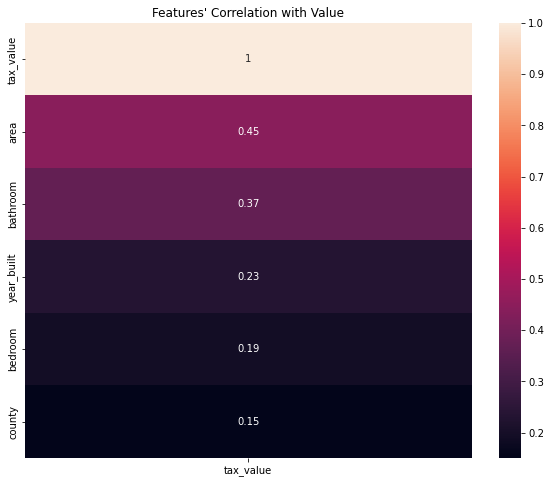

In [40]:
# create a dataframe of correlation values, sorted in descending order
corr = pd.DataFrame(train.corr().abs().tax_value).sort_values(by='tax_value', ascending=False)
# establish figure size
plt.figure(figsize=(10,8))
# creat the heatmap using the correlation dataframe created above
sns.heatmap(corr, annot=True)
# establish a plot title
plt.title('Features\' Correlation with Value')
# display the plot
plt.show()

<AxesSubplot:xlabel='county', ylabel='tax_value'>

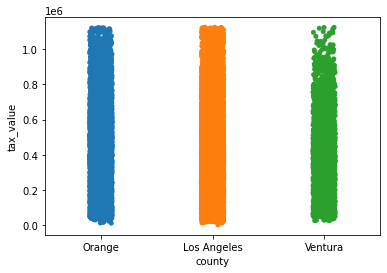

In [22]:
sns.stripplot(x= train.county,y=train.tax_value)



<AxesSubplot:xlabel='county', ylabel='tax_value'>

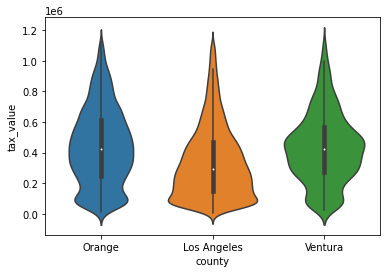

In [23]:
sns.violinplot(x= train.county,y=train.tax_value)


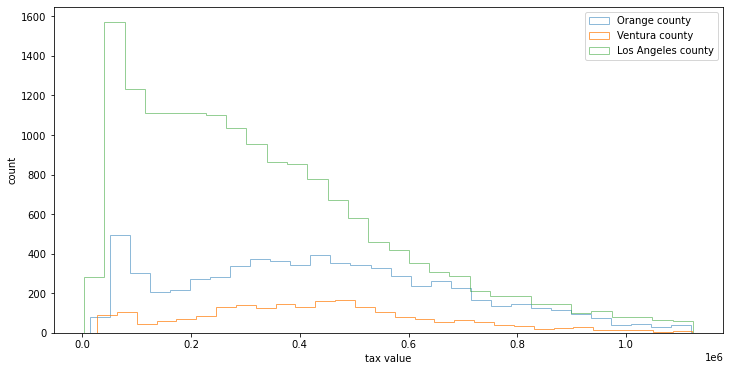

In [49]:
plt.figure(figsize = (12,6))
train[train.county == 'Orange'].tax_value.hist(label = "Orange county", bins = 30, alpha = 0.5, histtype = "step")
train[train.county == 'Ventura'].tax_value.hist(label = "Ventura county", bins = 30, alpha = 0.7, histtype = "step")
train[train.county == 'Los Angeles'].tax_value.hist(label = "Los Angeles county", bins = 30, alpha = 0.5,histtype ="step")
plt.grid(False)
plt.xlabel("tax value")
plt.ylabel("count")
plt.legend()
plt.show()

<AxesSubplot:xlabel='area', ylabel='tax_value'>

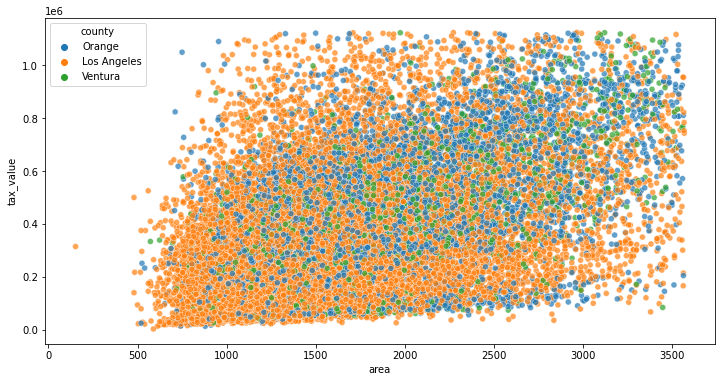

In [6]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = train.area, y = train.tax_value, hue= train.county, alpha = .7)

<AxesSubplot:xlabel='area', ylabel='tax_value'>

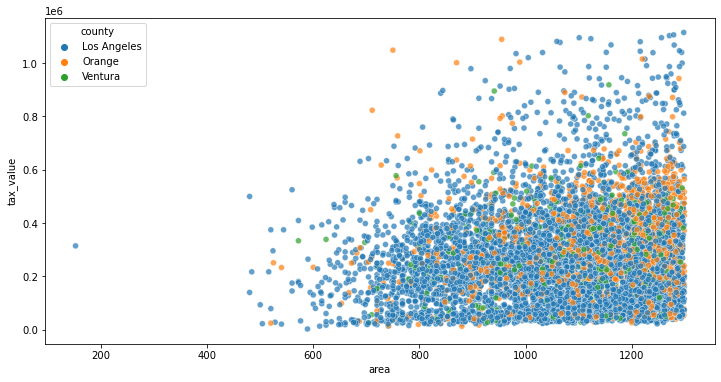

In [7]:
sample = train[train.area < 1300]
plt.figure(figsize = (12,6))
sns.scatterplot(x = sample.area, y = sample.tax_value, hue= sample.county, alpha = .7)

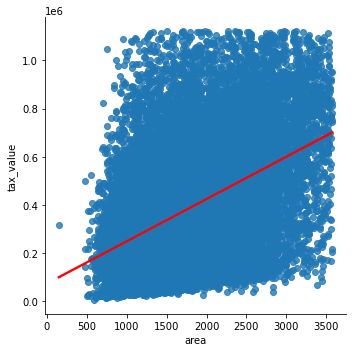

In [73]:
sns.lmplot(data = train, x = "area", y = "tax_value", line_kws={'color':'red'})

In [8]:

#X_train = train.drop(columns = "tax_value")
#y_train = train.tax_value
#viz.select_rfe(X_train,y_train,  n_features_to_select = 3)

<AxesSubplot:xlabel='year_built', ylabel='tax_value'>

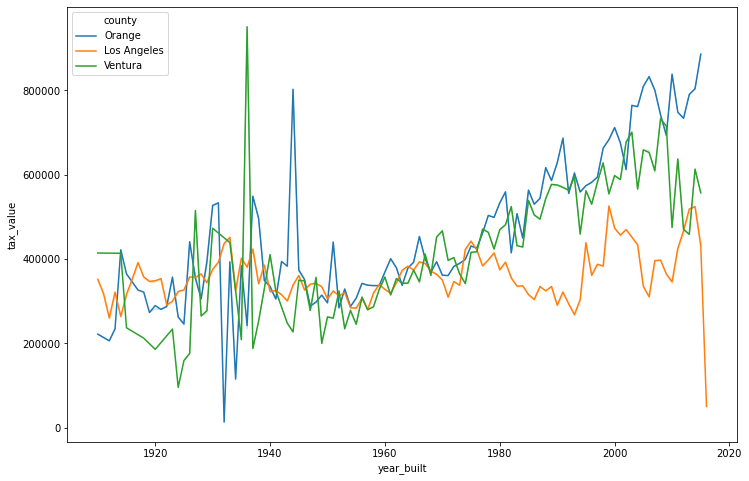

In [20]:
plt.figure(figsize = (12,8))
sns.lineplot(x = "year_built", y = "tax_value", data = train, hue = "county", ci = 0)

<AxesSubplot:xlabel='year_built', ylabel='tax_value'>

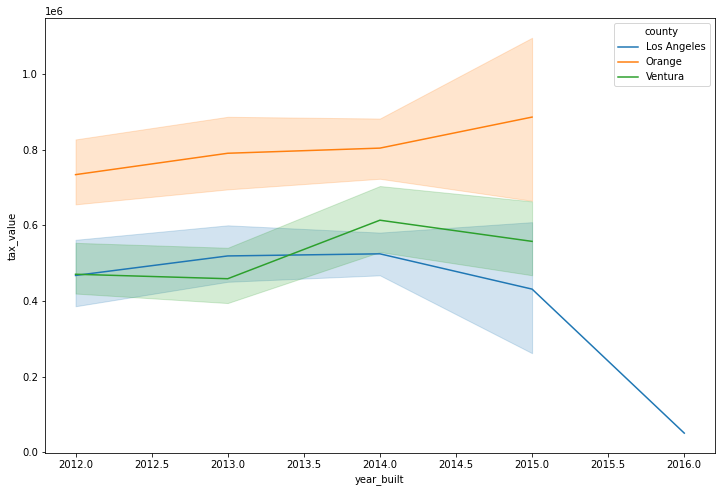

In [67]:
plt.figure(figsize = (12,8))
sns.lineplot(x = "year_built", y = "tax_value", data = train[train.year_built > 2011], hue = "county")

<AxesSubplot:xlabel='area', ylabel='tax_value'>

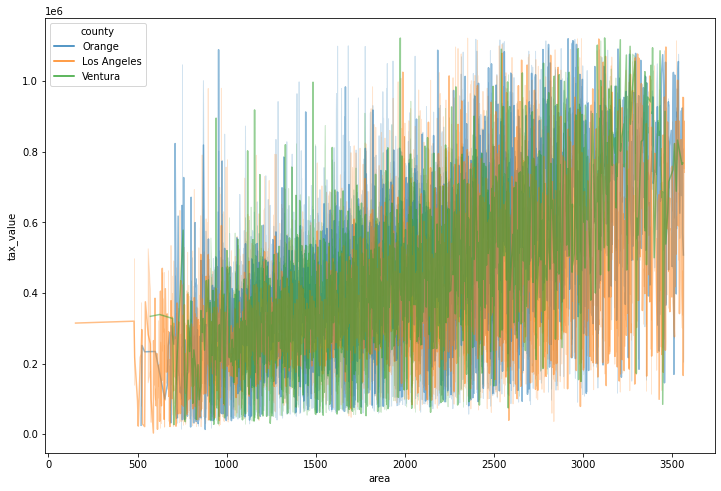

In [69]:
plt.figure(figsize = (12,8))
sns.lineplot(y = "tax_value", x = "area", data = train, hue = "county",alpha = 0.5)

<AxesSubplot:xlabel='year_built', ylabel='area'>

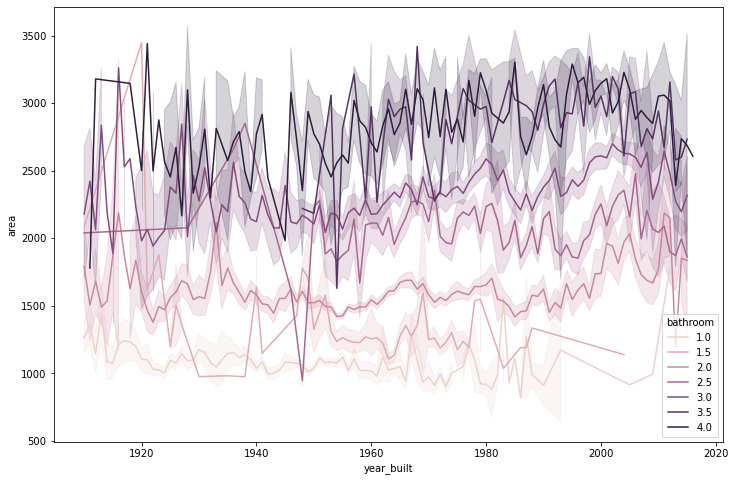

In [26]:
plt.figure(figsize = (12,8))
sns.lineplot(y = "area", x = "year_built", data = train, hue = "bathroom")

<AxesSubplot:>

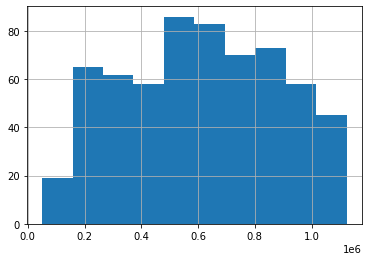

In [29]:
train[train.bathroom == 4.0].tax_value.hist()

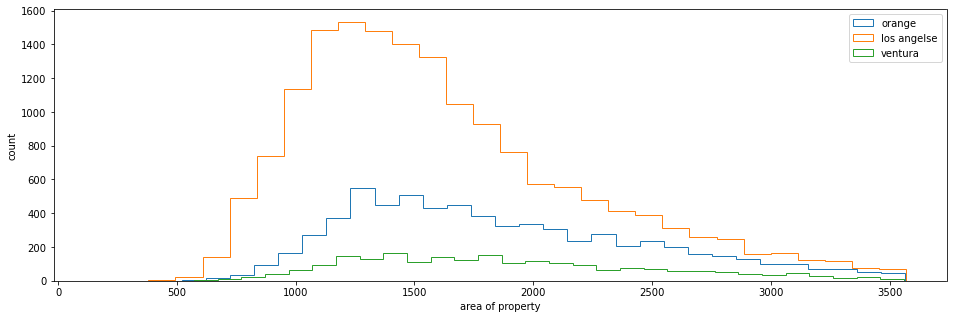

In [53]:
plt.figure(figsize =(16,5))
train[train.county == "Orange"].area.hist(alpha = 1, bins =30, label = "orange", histtype = "step")
train[train.county == "Los Angeles"].area.hist( alpha = 1, bins = 30, label = "los angelse", histtype = "step")
train[train.county== "Ventura"].area.hist(alpha = 1, bins =30, label = "ventura", histtype = "step")
plt.xlabel("area of property")
plt.ylabel("count")
plt.legend()
plt.grid(False)


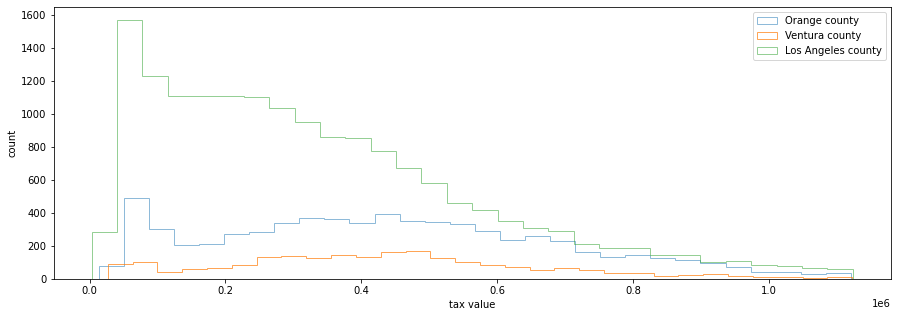

In [54]:
plt.figure(figsize = (15,5))
train[(train.county == 'Orange')].tax_value.hist(label = "Orange county", bins = 30, alpha = 0.5, histtype = "step")
train[train.county == 'Ventura'].tax_value.hist(label = "Ventura county", bins = 30, alpha = 0.7, histtype = "step")
train[train.county == 'Los Angeles'].tax_value.hist(label = "Los Angeles county", bins = 30, alpha = 0.5,histtype ="step")
plt.grid(False)
plt.xlabel("tax value")
plt.ylabel("count")
plt.legend()
plt.show()

In [33]:
train.county.unique()

array(['Orange', 'Los Angeles', 'Ventura'], dtype=object)

In [42]:
train.area.head()

30536    3415.0
17269    1652.0
28117    1252.0
39745    2380.0
6926     1268.0
Name: area, dtype: float64

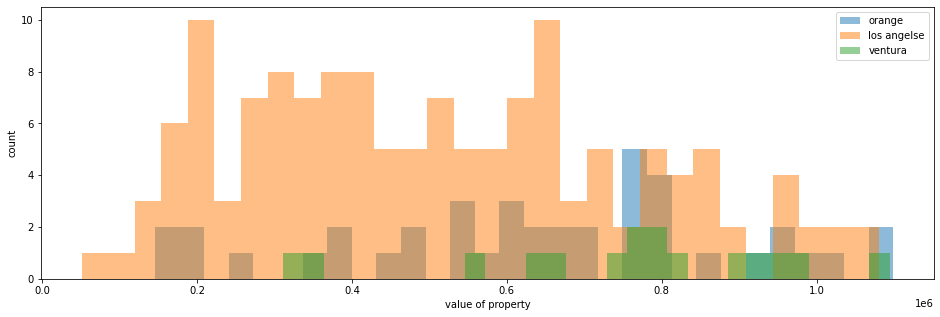

In [59]:
plt.figure(figsize =(16,5))
train[(train.county == "Orange")&(train.bathroom ==4)& (train.bedroom == 5)].tax_value.hist(alpha = .5,bins=30,label = "orange")
train[(train.county == "Los Angeles")&(train.bathroom ==4)& (train.bedroom == 5)].tax_value.hist(bins=30,alpha = .5,label = "los angelse")
train[(train.county== "Ventura")&(train.bathroom ==4)&(train.bedroom == 5)].tax_value.hist(bins=30,alpha = .5,label = "ventura")
plt.xlabel("value of property")
plt.ylabel("count")
plt.legend()
plt.grid(False)

In [8]:
features = ["area", "bathroom", "year_built"]

In [9]:
train,validate,test = viz.scale_data(train,validate,test,features)

In [10]:
train.head()

,bedroom,bathroom,area,tax_value,year_built,county,area_scaled,bathroom_scaled,year_built_scaled
0,5,3.0,3415.0,994000.0,1979.0,Orange,0.954931,0.666667,0.650943
1,3,2.0,1652.0,247632.0,1952.0,Los Angeles,0.438982,0.333333,0.396226
2,4,3.0,1252.0,344761.0,1912.0,Los Angeles,0.321920,0.666667,0.018868
3,5,2.5,2380.0,347513.0,1972.0,Orange,0.652034,0.500000,0.584906
4,3,2.0,1268.0,386856.0,1969.0,Orange,0.326602,0.333333,0.556604


In [11]:
X_train = train[["area_scaled","bathroom_scaled","year_built_scaled"]]
y_train = train[["tax_value"]]
X_validate = validate[["area_scaled","bathroom_scaled","year_built_scaled"]]
y_validate = validate[["tax_value"]]
X_test = test[["area_scaled","bathroom_scaled","year_built_scaled"]]
y_test = test[["tax_value"]]

In [12]:
y_train.head(1)

,tax_value
0,994000.0


Baseline RMSE values



In [13]:
#apply baseline value to train and validate
y_train["baseline_mean"] = y_train.tax_value.mean()
y_train["baseline_median"] =y_train.tax_value.median()
y_validate["baseline_mean"] = y_validate.tax_value.mean()
y_validate["baseline_median"] =y_validate.tax_value.median()

In [14]:
y_train.head(1)

,tax_value,baseline_mean,baseline_median
0,994000.0,373618.455712,336767.5


In [15]:
y_validate.head(1)

,tax_value,baseline_mean,baseline_median
0,364000.0,372585.126543,335676.0


In [16]:
train_rmse_mean=mean_squared_error(y_train.tax_value,y_train.baseline_mean, squared = False)
train_rmse_median= mean_squared_error(y_train.tax_value,y_train.baseline_median, squared = False)
validate_rmse_mean=mean_squared_error(y_validate.tax_value,y_validate.baseline_mean, squared = False)
validate_rmse_median= mean_squared_error(y_validate.tax_value,y_validate.baseline_median, squared = False)
print("Baseline RMSE on Train using mean is", round(train_rmse_mean,2))
print("Baseline RMSE on Train using median is", round(train_rmse_median,2))
print("Baseline RMSE on Validate using mean is", round(validate_rmse_mean,2))
print("Baseline RMSE on Validate using median is", round(validate_rmse_median,2))

Baseline RMSE on Train using mean is 243654.05
Baseline RMSE on Train using median is 246425.01
Baseline RMSE on Validate using mean is 244802.95
Baseline RMSE on Validate using median is 247569.73


In [17]:
#baseline mean is slightly better than median, will use mean

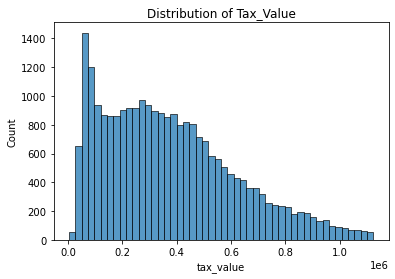

In [18]:
# peek at the distribution of my target varaible
sns.histplot(y_train.tax_value)
plt.title('Distribution of Tax_Value')
plt.show()

In [29]:
# lets make a metric df that assesses 
# out of sample model performance
metric_df = pd.DataFrame(
    [
        {
        'model': 'baseline_mean',
        'rmse': mean_squared_error(y_validate.tax_value,y_validate.baseline_mean, squared = False) ,
        'r^2': explained_variance_score(y_validate.tax_value,y_validate.baseline_mean)
        }
    ])                                 

In [30]:
metric_df

,model,rmse,r^2
0,baseline_mean,244802.954349,0.0


Linear regression


In [19]:
def linear_regression(X_train,y_train,X_validate,y_validate):

    # create the model object
    lm = LinearRegression(normalize = True)
    
    # Fit the model
    lm.fit(X_train, y_train.tax_value)
    
    # Predict y on train
    y_train['tax_value_pred_lm'] = lm.predict(X_train)
    # predict validate
    y_validate['tax_value_pred_lm'] = lm.predict(X_validate)
    
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

    print("RMSE for OLS using LinearRegression\nTraining/In-Sample", round(rmse_train, 2), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))
    
    

In [20]:
linear_regression(X_train,y_train,X_validate,y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample 218017.63 
Validation/Out-of-Sample:  219036.82


Lasso_lars

In [59]:
def lasso_lars(X_train, y_train, X_validate, y_validate, alpha):
    
    # create the model object
    lars = LassoLars(alpha)

    # fit the model.
    lars.fit(X_train, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_lars'] = lars.predict(X_train)
    # predict validate
    y_validate['tax_value_pred_lars'] = lars.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

    print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

In [60]:
#alpha =1
lasso_lars(X_train, y_train, X_validate, y_validate, alpha =1)

RMSE for Lasso + Lars
Training/In-Sample:  218017.71 
Validation/Out-of-Sample:  219036.79


In [61]:
for i in range(0,10):
    lasso_lars(X_train, y_train, X_validate, y_validate, alpha = i)

RMSE for Lasso + Lars
Training/In-Sample:  218017.63 
Validation/Out-of-Sample:  219036.82
RMSE for Lasso + Lars
Training/In-Sample:  218017.71 
Validation/Out-of-Sample:  219036.79
RMSE for Lasso + Lars
Training/In-Sample:  218017.95 
Validation/Out-of-Sample:  219036.92
RMSE for Lasso + Lars
Training/In-Sample:  218018.35 
Validation/Out-of-Sample:  219037.2
RMSE for Lasso + Lars
Training/In-Sample:  218018.9 
Validation/Out-of-Sample:  219037.64
RMSE for Lasso + Lars
Training/In-Sample:  218019.57 
Validation/Out-of-Sample:  219038.41
RMSE for Lasso + Lars
Training/In-Sample:  218020.28 
Validation/Out-of-Sample:  219039.56
RMSE for Lasso + Lars
Training/In-Sample:  218021.13 
Validation/Out-of-Sample:  219040.84
RMSE for Lasso + Lars
Training/In-Sample:  218022.11 
Validation/Out-of-Sample:  219042.24
RMSE for Lasso + Lars
Training/In-Sample:  218023.22 
Validation/Out-of-Sample:  219043.78


Tweedie_regressor

In [62]:
def Tweedie_regressor(X_train, y_train, X_validate, y_validate, power, alpha):

    # create the model object
    glm = TweedieRegressor(power=power, alpha=alpha)

    # fit the model to our training data.
    glm.fit(X_train, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_glm'] = glm.predict(X_train)
    # predict validate
    y_validate['tax_value_pred_glm'] = glm.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)
    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", power, " & alpha=", alpha, 
        "\nTraining/In-Sample: ", round(rmse_train, 2), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

In [63]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, 0, 0)

RMSE for GLM using Tweedie, power= 0  & alpha= 0 
Training/In-Sample:  218017.63 
Validation/Out-of-Sample:  219036.82


In [64]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, 0, 1)

RMSE for GLM using Tweedie, power= 0  & alpha= 1 
Training/In-Sample:  240101.3 
Validation/Out-of-Sample:  241288.98


In [65]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, 0, 2)

RMSE for GLM using Tweedie, power= 0  & alpha= 2 
Training/In-Sample:  241760.95 
Validation/Out-of-Sample:  242931.62


In [66]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, 1, 0)

RMSE for GLM using Tweedie, power= 1  & alpha= 0 
Training/In-Sample:  218057.88 
Validation/Out-of-Sample:  218671.96


In [67]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, 2, 1)

RMSE for GLM using Tweedie, power= 2  & alpha= 1 
Training/In-Sample:  240131.55 
Validation/Out-of-Sample:  241308.67


Polynomial regression

In [23]:
def polynomial_regression(X_train, y_train, X_validate, y_validate, degree):
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree= degree)
    
    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)
    

    # transform X_validate_scaled 
    X_validate_degree2 = pf.transform(X_validate)

    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

    # predict validate
    y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

    print("RMSE for Polynomial Model, degrees=", degree, "\nTraining/In-Sample: ", rmse_train, 
        "\nValidation/Out-of-Sample: ", rmse_validate)

In [70]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=2)

RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  217145.9001203359 
Validation/Out-of-Sample:  217587.11698504456


In [24]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=3)

RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  216788.74684460962 
Validation/Out-of-Sample:  217362.52078691905


In [25]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=4)

RMSE for Polynomial Model, degrees= 4 
Training/In-Sample:  216072.8115794653 
Validation/Out-of-Sample:  216555.9726652814


In [26]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=5)

RMSE for Polynomial Model, degrees= 5 
Training/In-Sample:  215107.3127189109 
Validation/Out-of-Sample:  215571.8961100373


In [27]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=6)

RMSE for Polynomial Model, degrees= 6 
Training/In-Sample:  213684.5698480385 
Validation/Out-of-Sample:  214427.24621371628


In [28]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree=10)

RMSE for Polynomial Model, degrees= 10 
Training/In-Sample:  211577.43052279594 
Validation/Out-of-Sample:  223209.98496339066


In [29]:
linear_regression(X_train,y_train,X_validate,y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample 218017.63 
Validation/Out-of-Sample:  219036.82


In [30]:
X_train.head()

,area_scaled,bathroom_scaled,year_built_scaled
0,0.954931,0.666667,0.650943
1,0.438982,0.333333,0.396226
2,0.321920,0.666667,0.018868
3,0.652034,0.500000,0.584906
4,0.326602,0.333333,0.556604


In [85]:
def test_prediction(X_train,y_train,X_test,y_test,degree):
    pf = PolynomialFeatures(degree= degree)
    
    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)
    
    X_test_degree2 = pf.transform(X_test)

    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.tax_value)

     # predict test
    y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

    # evaluate: test rmse
    rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

    print("RMSE for Polynomial Model, degrees=", degree, "\ntest: ", rmse_test, "\nr^2: ", explained_variance_score(y_test.tax_value,
                                           y_test.tax_value_pred_lm2))

    print()
    plt.figure(figsize = (15,6))
    sns.lmplot(data = y_test, x= "tax_value", y="tax_value_pred_lm2",line_kws={'color':'red'} )
    plt.title("actual vs predicted tax value")
    plt.xlabel("actual tax value")
    plt.ylabel("predicated tax value")

    plt.show()

RMSE for Polynomial Model, degrees= 5 
test:  218218.39357439074 
r^2:  0.22335653866238325



<Figure size 1080x432 with 0 Axes>

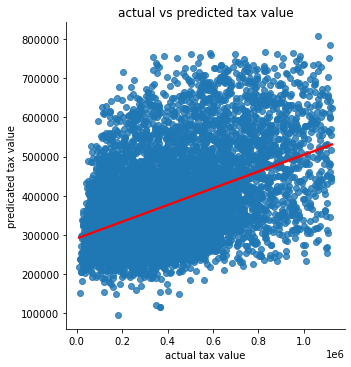

In [86]:
test_prediction(X_train,y_train,X_test,y_test,degree =5)

In [88]:
pf = PolynomialFeatures(degree= 2)
    
    # fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
X_test_degree2 = pf.transform(X_test)

    # create the model object
lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

     # predict test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

    # evaluate: test rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=", 2, "\ntest: ", rmse_test, "/nr^2: ", explained_variance_score(y_test.tax_value,
                                           y_test.tax_value_pred_lm2))


RMSE for Polynomial Model, degrees= 2 
test:  220032.5738446767 /nr^2:  0.21037916101351972


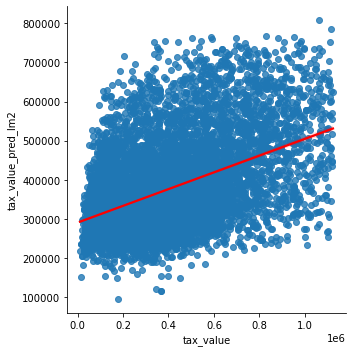

In [51]:
sns.lmplot(data = y_test, x= "tax_value", y="tax_value_pred_lm2",line_kws={'color':'red'} )